In [1]:
import pandas as pd
import os
import numpy as np
import random
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
kick1 = pd.read_csv('kick1.dat', sep = ' ', header = None, names = ['x', 'y', 'z'])
kick2 = pd.read_csv('kick2.dat', sep = ' ', header = None, names = ['x', 'y', 'z'])

y1 = np.array(kick1['y'])
x1 = np.array(kick1['x'])
z1 = np.array(kick1['z'])

y2 = np.array(kick2['y'])
x2 = np.array(kick2['x'])
z2 = np.array(kick2['z'])

time = np.linspace(0, 1, 20)

print(z2)

[0.145 0.177 0.172 0.167 0.192 0.219 0.213 0.223 0.25  0.244 0.233 0.269
 0.283 0.29  0.263 0.29  0.28  0.281 0.296 0.269]


In [2]:
def gradiente_ssr(t, y, b):
    if(t.size != y.size):
        raise Exception("Os vetores t e y devem ter o mesmo tamanho.")
    
    res1 = 0
    res2 = 0
    for i in range(t.size):
        res1 += b[0] + b[1] * t[i] - y[i]
    for i in range(t.size):
        res2 += (b[0] + b[1]* t[i] - y[i]) * t[i]
    return res1/t.size, res2/t.size

def gradient_descente(gradient_ssr, t, y, coeff_start, learning_rate=0.1, n_iter=50, tolerance=1e-11):
    coeff_output = coeff_start
    for _ in range(n_iter):
        diff = -learning_rate * np.array(gradient_ssr(t, y, coeff_output))
        if np.all(np.abs(diff) <= tolerance):
            print(np.abs(diff))
            print(tolerance)
            break
        coeff_output += diff
    return coeff_output

def predict_points(coefficients, time):
    lin_function = lambda b0, b1, t: b0 + b1*t
    points_array = []
    for t in time:
        points_array.append(lin_function(coefficients[0], coefficients[1], t))
    return points_array


In [3]:
def loss_mse(ys, y_bar):
    return sum((ys - y_bar)*(ys - y_bar)) / len(ys)

def eval_2nd_degree(coeffs, x):
    a = (coeffs[0]*(x*x))
    b = coeffs[1]*x
    c = coeffs[2]
    y = a+b+c
    return y

def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    a_s = []
    b_s = []
    c_s = []
        
    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x**2        
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y-y_bar)
        b_s.append(partial_b)
        partial_c = (y-y_bar)
        c_s.append(partial_c)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    
    new_model_coeffs = (a_new, b_new, c_new)
    
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar
    

def gradient_descent(epochs, lr, x_inputs, y_outputs):
    losses = []
    rand_coeffs_to_test = (random.randrange(-1, 0)/2, random.randrange(-1, 1)/2, y_outputs[0])

    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, x_inputs, y_outputs, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    return loss[0], loss[1], loss[2], losses, rand_coeffs_to_test


In [4]:
coeff_y1 = gradient_descente(gradiente_ssr, time, y1, coeff_start=[2.1, -.975], learning_rate=0.0000001, n_iter=100000)
coeff_x1 = gradient_descente(gradiente_ssr, time, x1, coeff_start=[-.22, -1], learning_rate=0.0000001, n_iter=100000)

[0.09661694 0.10703436 0.1161457  0.12395098 0.13045019 0.13564333
 0.13953041 0.14211143 0.14338637 0.14335525 0.14201807 0.13937481
 0.13542549 0.13017011 0.12360866 0.11574114 0.10656756 0.09608791
 0.08430219 0.07121041]
(-0.23574496679371706, 0.21033842881656425, 0.0966169449815525)


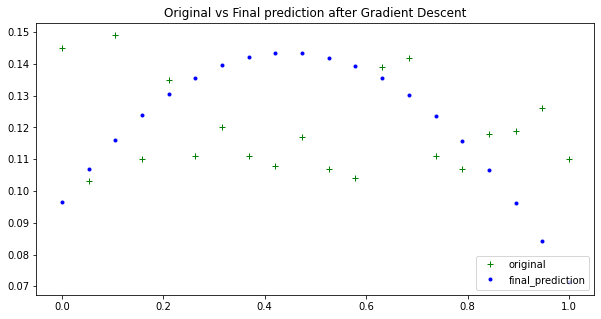

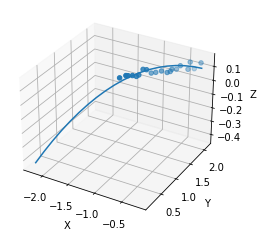

[0.09661694 0.10703436 0.1161457  0.12395098 0.13045019 0.13564333
 0.13953041 0.14211143 0.14338637 0.14335525 0.14201807 0.13937481
 0.13542549 0.13017011 0.12360866 0.11574114 0.10656756 0.09608791
 0.08430219 0.07121041]
(-0.23574496679371706, 0.21033842881656425, 0.0966169449815525)


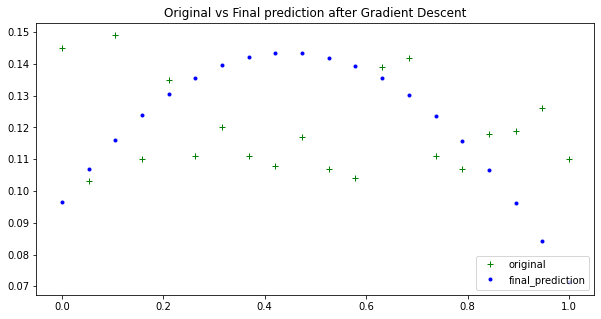

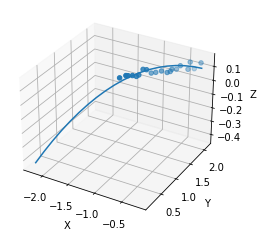

[0.09661694 0.10703436 0.1161457  0.12395098 0.13045019 0.13564333
 0.13953041 0.14211143 0.14338637 0.14335525 0.14201807 0.13937481
 0.13542549 0.13017011 0.12360866 0.11574114 0.10656756 0.09608791
 0.08430219 0.07121041]
(-0.23574496679371706, 0.21033842881656425, 0.0966169449815525)


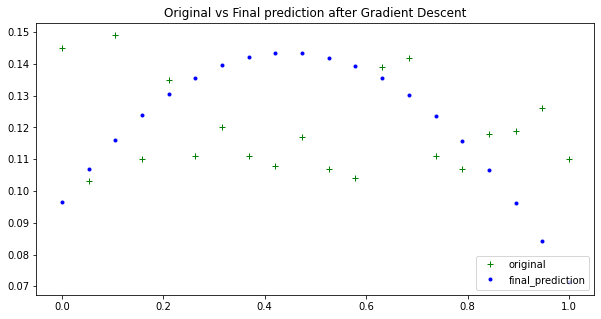

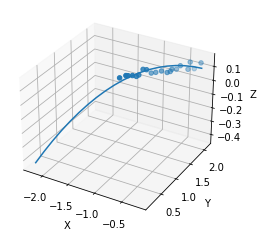

[0.14774223 0.14565418 0.14347322 0.14119936 0.13883259 0.13637291
 0.13382032 0.13117482 0.12843641 0.1256051  0.12268088 0.11966375
 0.11655371 0.11335076 0.1100549  0.10666614 0.10318447 0.09960988
 0.0959424  0.092182  ]
(-0.016769953167797568, -0.038790277003233675, 0.14774222797989206)


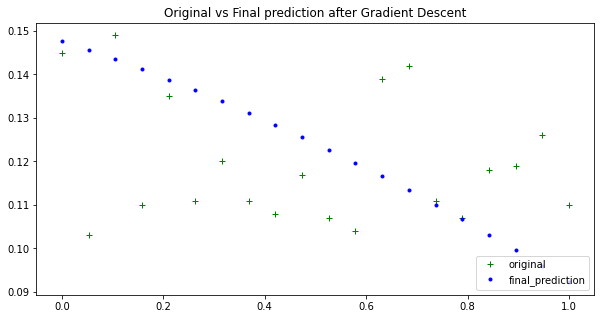

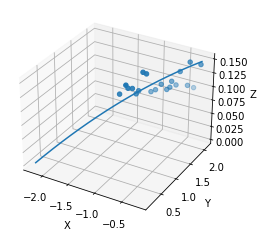

[0.14774223 0.14565418 0.14347322 0.14119936 0.13883259 0.13637291
 0.13382032 0.13117482 0.12843641 0.1256051  0.12268088 0.11966375
 0.11655371 0.11335076 0.1100549  0.10666614 0.10318447 0.09960988
 0.0959424  0.092182  ]
(-0.016769953167797568, -0.038790277003233675, 0.14774222797989206)


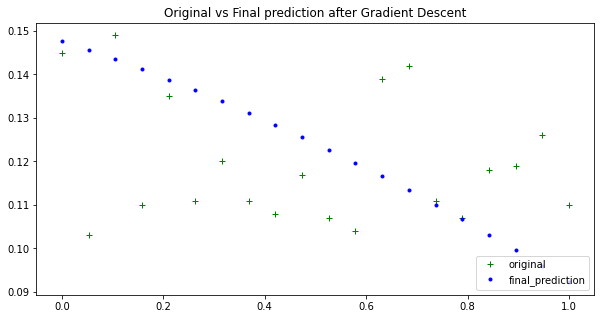

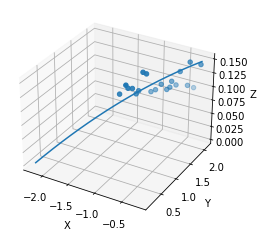

In [5]:
for i in range(5):
    GD = gradient_descent(100000, 0.0001, time, z1)
    time1 = np.linspace(0, 2, 20)
    y1_predicted = predict_points(coeff_y1, time1)
    x1_predicted = predict_points(coeff_x1, time1)

    z1_predicted = eval_2nd_degree(GD[4], time1)
    #plt.figure(figsize=(20,10))
    print(GD[2])
    print(GD[4])
    plt.figure(figsize=(10,5))
    plt.plot(time, z1, 'g+', label = 'original')
    plt.plot(time, GD[2], 'b.', label = 'final_prediction')
    plt.title('Original vs Final prediction after Gradient Descent')
    plt.legend(loc="lower right")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x1, y1, z1);
    ax.plot(x1_predicted, y1_predicted, z1_predicted)
    plt.show()

In [6]:
coeff_y2 = gradient_descente(gradiente_ssr, time, y2, coeff_start=[y2[0], -.975], learning_rate=0.0000001, n_iter=100000)
coeff_x2 = gradient_descente(gradiente_ssr, time, x2, coeff_start=[x2[0], -.5], learning_rate=0.0000001, n_iter=100000)

[0.15447987 0.16969414 0.18386819 0.197002   0.20909559 0.22014895
 0.23016208 0.23913498 0.24706766 0.2539601  0.25981232 0.26462431
 0.26839607 0.2711276  0.2728189  0.27346998 0.27308082 0.27165144
 0.26918183 0.26567199]
(-0.18776125921026068, 0.29895338081156, 0.15447986550265388)


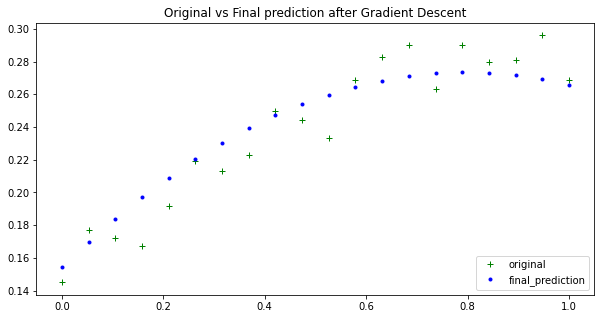

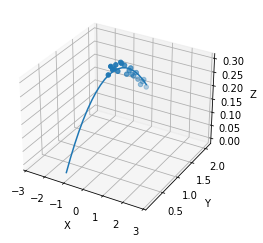

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


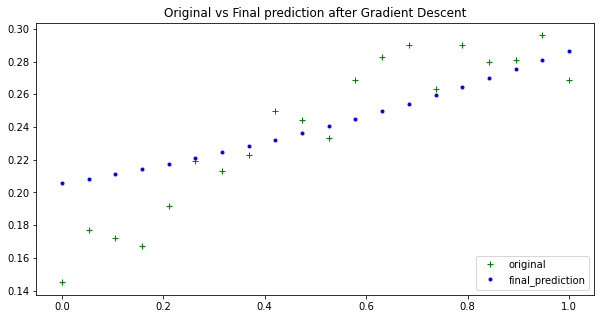

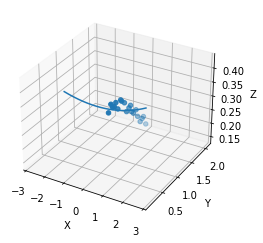

[0.15447987 0.16969414 0.18386819 0.197002   0.20909559 0.22014895
 0.23016208 0.23913498 0.24706766 0.2539601  0.25981232 0.26462431
 0.26839607 0.2711276  0.2728189  0.27346998 0.27308082 0.27165144
 0.26918183 0.26567199]
(-0.18776125921026068, 0.29895338081156, 0.15447986550265388)


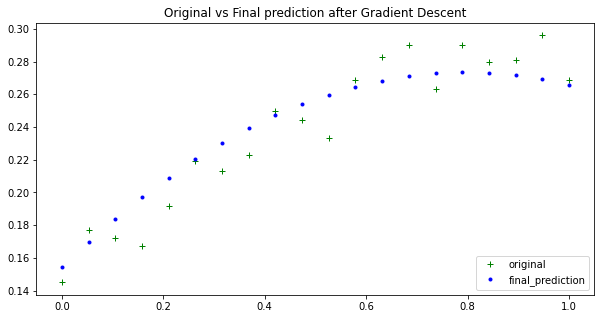

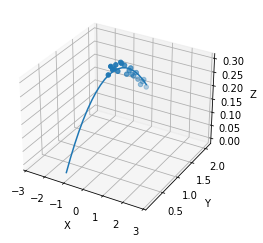

[0.15447987 0.16969414 0.18386819 0.197002   0.20909559 0.22014895
 0.23016208 0.23913498 0.24706766 0.2539601  0.25981232 0.26462431
 0.26839607 0.2711276  0.2728189  0.27346998 0.27308082 0.27165144
 0.26918183 0.26567199]
(-0.18776125921026068, 0.29895338081156, 0.15447986550265388)


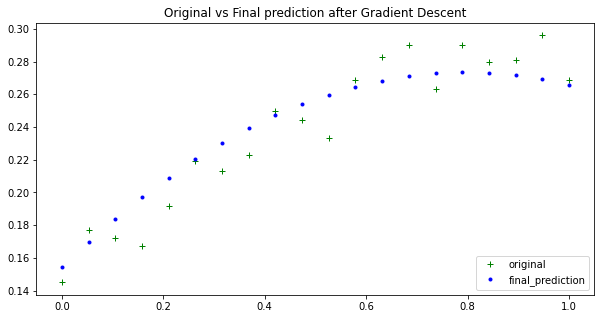

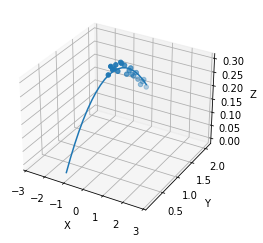

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


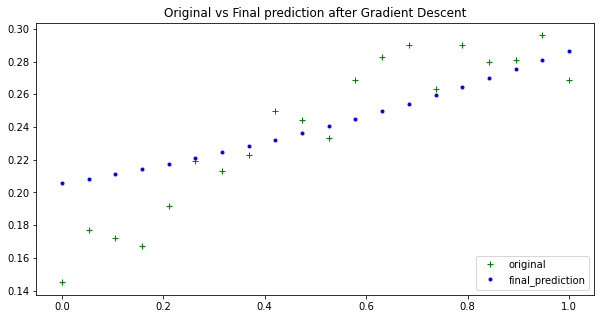

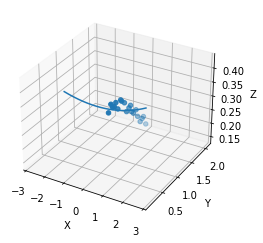

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


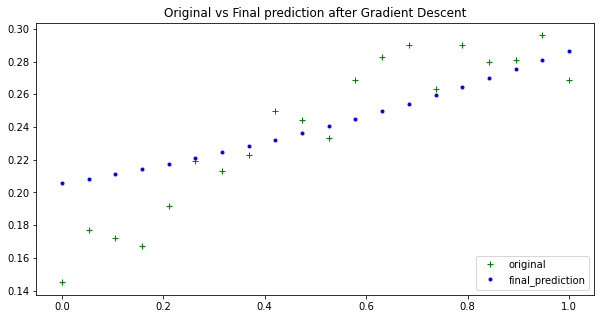

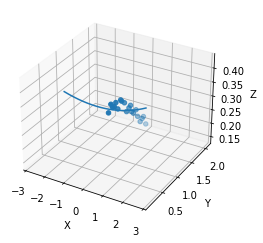

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


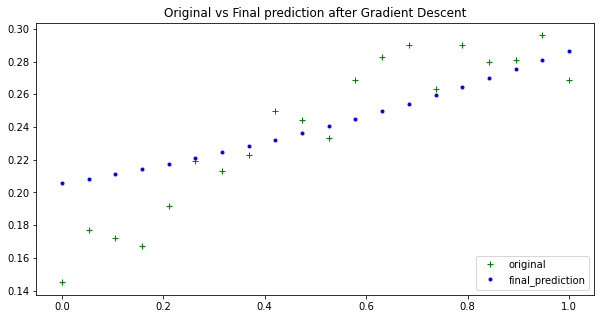

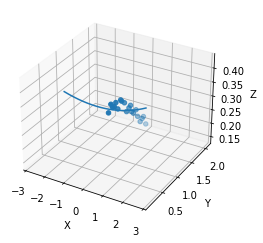

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


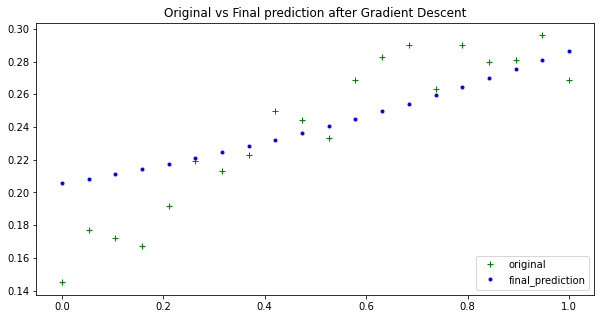

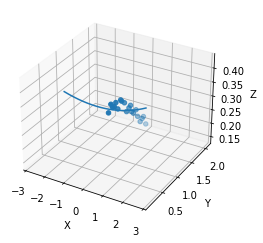

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


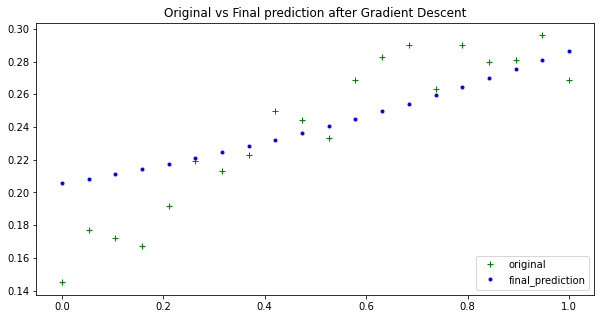

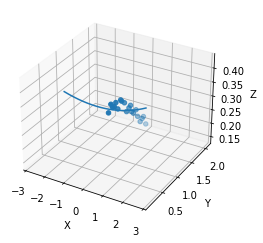

[0.15447987 0.16969414 0.18386819 0.197002   0.20909559 0.22014895
 0.23016208 0.23913498 0.24706766 0.2539601  0.25981232 0.26462431
 0.26839607 0.2711276  0.2728189  0.27346998 0.27308082 0.27165144
 0.26918183 0.26567199]
(-0.18776125921026068, 0.29895338081156, 0.15447986550265388)


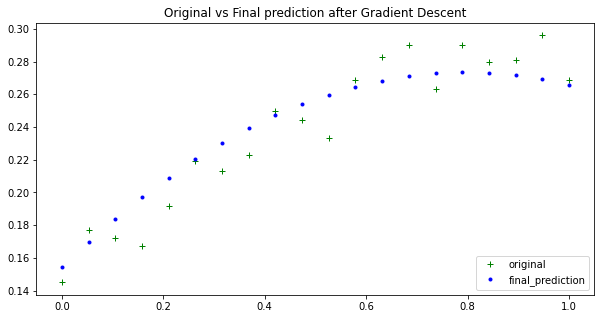

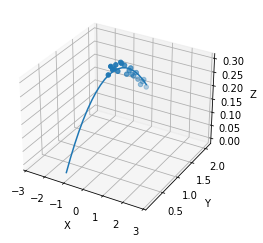

In [7]:
for i in range(10):
    GD = gradient_descent(100000, 0.0001, time, z2)
    time2 = np.linspace(0, 2, 20)
    y2_predicted = predict_points(coeff_y2, time2)
    x2_predicted = predict_points(coeff_x2, time2)

    z2_predicted = eval_2nd_degree(GD[4], time2)
    #plt.figure(figsize=(20,10))
    print(GD[2])
    print(GD[4])
    plt.figure(figsize=(10,5))
    plt.plot(time, z2, 'g+', label = 'original')
    plt.plot(time, GD[2], 'b.', label = 'final_prediction')
    plt.title('Original vs Final prediction after Gradient Descent')
    plt.legend(loc="lower right")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.set_xlim3d(-3, 3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x2, y2, z2);
    ax.plot(x2_predicted, y2_predicted, z2_predicted)
    plt.show()

In [8]:
(-0.1615903286081297, 0.30266520430516175, 0.14174138771351372)

(-0.1615903286081297, 0.30266520430516175, 0.14174138771351372)

In [9]:
time = np.linspace(0, 1, 20)
time2 = np.linspace(1, 2, 20)
print(time)
print(time2)

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
[1.         1.05263158 1.10526316 1.15789474 1.21052632 1.26315789
 1.31578947 1.36842105 1.42105263 1.47368421 1.52631579 1.57894737
 1.63157895 1.68421053 1.73684211 1.78947368 1.84210526 1.89473684
 1.94736842 2.        ]
